# Задача кредитного скоринга

Имеются следующие данные о кредитных историях клиентов одного из банков:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский)
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

**Необходимо:**

    1. В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверить гипотезы: 
        a) о равенстве медианных значений кредитного лимита (`LIMIT_BAL`) с помощью подходящей интервальной оценки 
        b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних
    2. Проверить гипотезу о том, что гендерный состав группы людей (`SEX`) вернувших и не вернувших кредит отличается.
    3. Проверить гипотезу о том, что образование (`EDUCATION`) не влияет на то, вернет ли человек долг.
    4. Проверить, как связан семейный статус (`MARRIAGE`) с индикатором дефолта.
    5. Относительно двух групп людей вернувших и не вернувших кредит проверить следующие гипотезы: 
        a) о равенстве медианных значений возрастов людей (`AGE`)
        b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

**Подготовим данные**

In [1]:
default = {0:'кредит возвращен', 
           1:'кредит не возвращен'}

SEX = {1:'мужчины', 
       2:'женщины'}

EDUCATION = {0:'доктор',
             1:'магистр',
             2:'бакалавр',
             3:'выпускник школы',
             4:'начальное образование',
             5:'прочее',
             6:'нет данных'}

MARRIAGE = {0:'отказ отвечать',
            1:'замужем/женат',
            2:'холост',
            3:'нет данных'}

In [2]:
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

from matplotlib import pyplot

import numpy as np
import pandas as pd
import seaborn as sns

import scipy

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("credit_card_default_analysis.csv", header=0, index_col='ID') 

In [4]:
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,0,0,0,0,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,0,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [5]:
# Сводная информация о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(24)
memory usage: 5.7 MB


In [6]:
# Категориальные признаки
categorical_features = ['EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Бинарные признаки
binary_features = ['SEX', 'default']

# Вещественные признаки
real_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 
                 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [7]:
# Сбалансированность бинарных признаков
for feature in binary_features:
    print(feature)
    print('___________________________________________')
    print(f'category\tcount\t\tpercentage')
    for index, value in zip(data[feature].value_counts().index, data[feature].value_counts().values):
        print(f'{index}\t\t{value}\t\t{(value/np.sum(data[feature].value_counts().values)*100):.3f}%')
    print()

SEX
___________________________________________
category	count		percentage
2		18112		60.373%
1		11888		39.627%

default
___________________________________________
category	count		percentage
0		23364		77.880%
1		6636		22.120%



Бинарные признаки сбалансированы

In [8]:
# Сбалансированность категориальных признаков
for feature in categorical_features:
    print(feature)
    print('___________________________________________')
    print(f'category\tcount\t\tpercentage')
    for index, value in zip(data[feature].value_counts().index, data[feature].value_counts().values):
        print(f'{index}\t\t{value}\t\t{(value/np.sum(data[feature].value_counts().values)*100):.3f}%')
    print()

EDUCATION
___________________________________________
category	count		percentage
2		14030		46.767%
1		10585		35.283%
3		4917		16.390%
5		280		0.933%
4		123		0.410%
6		51		0.170%
0		14		0.047%

MARRIAGE
___________________________________________
category	count		percentage
2		15964		53.213%
1		13659		45.530%
3		323		1.077%
0		54		0.180%

PAY_0
___________________________________________
category	count		percentage
0		23182		77.273%
1		3688		12.293%
2		2667		8.890%
3		322		1.073%
4		76		0.253%
5		26		0.087%
8		19		0.063%
6		11		0.037%
7		9		0.030%

PAY_2
___________________________________________
category	count		percentage
0		25562		85.207%
2		3927		13.090%
3		326		1.087%
4		99		0.330%
1		28		0.093%
5		25		0.083%
7		20		0.067%
6		12		0.040%
8		1		0.003%

PAY_3
___________________________________________
category	count		percentage
0		25787		85.957%
2		3819		12.730%
3		240		0.800%
4		76		0.253%
7		27		0.090%
6		23		0.077%
5		21		0.070%
1		4		0.013%
8		3		0.010%

PAY_4
_____________________

В категориальных признаках наблюдается сильная разнородность: на 1-3 наиболее распространенных признака приходится более 98% выборки, на 4-6 наименее распространенных признака приходится менее 2% выборки.

### Задача 1

В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверить гипотезы: 

    a) о равенстве медианных значений кредитного лимита (`LIMIT_BAL`) с помощью подходящей интервальной оценки 
    b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

#### 1.1 Точечная оценка

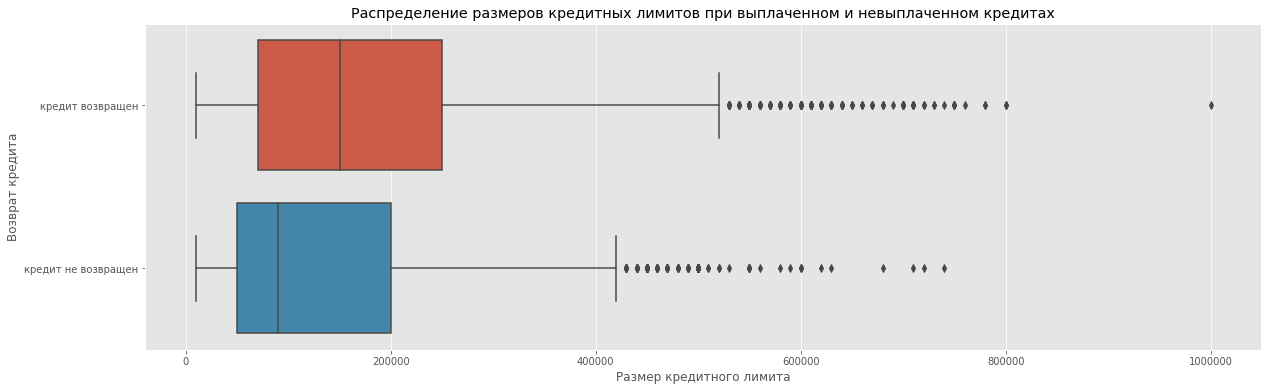

In [14]:
fig, nx = pyplot.subplots(figsize=(20,6))

sns.boxplot(y='default', x='LIMIT_BAL', data=data, orient='h')

pyplot.title(f'Распределение размеров кредитных лимитов при выплаченном и невыплаченном кредитах')
pyplot.ylabel('Возврат кредита')
pyplot.xlabel('Размер кредитного лимита')
pyplot.yticks(list(default.keys()), list(default.values()))
pyplot.ylim(1.5, -0.5)
    
pyplot.show()

По boxplot видно: 
* области интерквантильных размахов [25%-й квантиль, 75%-й квантиль] пересекаются и лежат в одном диапазоне;
* медиана рамзмера кредитного лимита при выплаченных кредитах больше таковой при невыплаченных;
* размер крединтных лимитов в обоих случаях выплаты имеет тяжелые хвосты, выходящие за  1.5-ый интерквартильный размах в большую сторону 

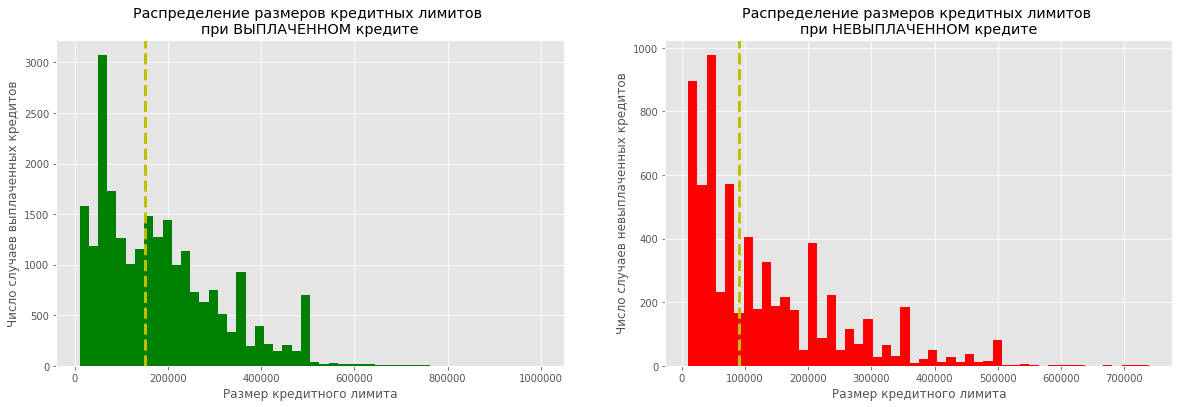

In [31]:
fig, nx = pyplot.subplots(1, 2, figsize=(20,6))

pyplot.subplot(1,2,1)
pyplot.hist(data[data['default'] == 0]['LIMIT_BAL'], bins=50, color = 'g')
pyplot.axvline(np.median(data[data['default'] == 0]['LIMIT_BAL']), color='y', linestyle='dashed', linewidth=3)
pyplot.title(f'Распределение размеров кредитных лимитов \nпри ВЫПЛАЧЕННОМ кредите')
pyplot.ylabel('Число случаев выплаченных кредитов')
pyplot.xlabel('Размер кредитного лимита')

pyplot.subplot(1,2,2)
pyplot.hist(data[data['default'] == 1]['LIMIT_BAL'], bins=50, color = 'r')
pyplot.axvline(np.median(data[data['default'] == 1]['LIMIT_BAL']), color='y', linestyle='dashed', linewidth=3)
pyplot.title(f'Распределение размеров кредитных лимитов \nпри НЕВЫПЛАЧЕННОМ кредите')
pyplot.ylabel('Число случаев невыплаченных кредитов')
pyplot.xlabel('Размер кредитного лимита')

pyplot.show()

По гистограммам размеров кредитных лимитов при обоих вариантах выплыт видно:
* наиболее часто невыплачиваемый размер кредита составляет менее 100 тыс.
* величина невозвратных кредитов не превосходит 750 тыс.
* число невыплаченных кридитов нелинейной падает с ростом размера крединтого лимита

#### 1.2 Проверка гипотезы о равенстве медианных значений кредитного лимита в группах людей, кто вернул кредит и тех, кто его не вернул

$H_0$: $med_{default=0}=med_{default=1}$

$H_1$: $med_{default=0}\neq med_{default=1}$

**Применим интервальную оценку медианы для каждой из двух выборок**

In [21]:
# Bootstrap

def get_bootstrap_samples(data, n_samples):
    
    """Возвращает заданное количество подвыборок n_samples сгенерированных на основе генеральной выборки data"""
    
    # Генерируется n_samples наборов индексов из доступного (исходного) диапазона. 
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    
    # Набор индексов применяется к исходным данным для получения непосредственных подвыборок.
    samples = data[indices]
    
    return samples


def stat_intervals(stat, alpha):
    """Возвращает границы доверительного интервала по значению статистики stat и уровня значимости alpha"""
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

In [78]:
# В качестве статистики используется медиана (np.median)
np.random.seed(0)

data_0 = data[data['default'] == 0]['LIMIT_BAL'].values
data_1 = data[data['default'] == 1]['LIMIT_BAL'].values

# Получение списков статистик (медиан)
# Количество подвыборок задается одинаковым не смотря на разницу в объемах данных для различных групп
data_0_median_scores = list(map(np.median, get_bootstrap_samples(data_0, 10000)))
data_1_median_scores = list(map(np.median, get_bootstrap_samples(data_1, 10000)))

# По набору статистик строится 95%-ый доверительный интервал статистики
print("95% confidence interval for data_0:",  stat_intervals(data_0_median_scores, 0.05))
print("95% confidence interval for data_1:",  stat_intervals(data_1_median_scores, 0.05))

95% confidence interval for data_0: [150000. 150000.]
95% confidence interval for data_1: [80000. 90000.]


По полученным оценкам видно, что медианная величина кредитного лимита в группах людей, выплативших кредит, выше, чем таковая для людей, не выплативших кредит.

**Для получения более точных данных применим интервальную оценку разности медиан двух выборок**

Алгоритм:

1. Генерируется по $n$ подвыборок из исходной генеральной выборки для каждой группы при помощи бустрепа.

2. Для каждой подвыборки для каждой группы вычисляется статистика.

3. Вычисляется попарная разность статистик (медиан) для списков медиан каждой группы.

4. По набору разностей статистик строится 95%-ый доверительный интервал статистики.

In [23]:
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(data_0_median_scores, data_1_median_scores)))

In [24]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [60000. 70000.]


**Таким образом видно, что разница между медианными значениями величины кредитного лимита в группах людей, выплативших кредит, и людей, не выплативших кредит, находится в диапазоне [60000. 70000.]. Медиана рамзмера кредитного лимита при выплаченных кредитах больше таковой при невыплаченных.**

Вероятнее всего, данная разница является значимой с практической точки зрения.

#### 1.3 Проверка гипотезы о равенстве распределений значений кредитного лимита в группах людей, кто вернул кредит и тех, кто его не вернул

**Перестановочный критерий**

Нулевая гипотеза: функции распределения для первой и второй выборки одинаковы.

Альтернативная гипотеза: функция распределения одной выборки получается сдвигом на некоторую дельту из функции распределения на другой выборке.

$H_0\colon F_{LIMIT-BAL_{default=0}}(x) = F_{LIMIT-BAL_{default=1}}(x)$

$H_1\colon F_{LIMIT-BAL_{default=0}}(x) = F_{LIMIT-BAL_{default=1}}(x + \Delta), \Delta\neq 0$

In [25]:
import itertools

def permutation_t_stat_ind(sample1, sample2):
    """Возвращает t-статистику"""
    return np.mean(sample1) - np.mean(sample2)


def get_random_combinations(n1, n2, max_combinations):
    """Возвращает заданное количество случаных комбинаций возможных перестановок"""
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]


def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    """Возвращает нулевое распределение"""
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr


def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    """Возвращает значение p-value"""
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1 if abs(x) >= abs(t_stat) else 0 for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1 if x <= t_stat else 0 for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1 if x >= t_stat else 0 for x in zero_distr]) / len(zero_distr)

In [84]:
# p-value при ограничении на количество перестановок в 10000
print("p-value: %f" % permutation_test(data_0, data_1, max_permutations = 10000))

p-value: 0.000100


Значение p-value меньше 0.05, что позволяет отвергнуть нулевую гипотезу на уровне значимости 0.05. **Распределение значений кредитного лимита в группах людей, кто вернул кредит и тех, кто его не вернул отличаются.**

**Ранговый критерий Манна-Уитни**

Нулевая гипотеза: вероятность того, что значение из первой выборки будет больше, чем значение из второй выборки, равна вероятности того, что значение из второй выборки будет больше, чем значение из первой выборки.

Альтернативная гипотеза: не равна.


$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [77]:
from scipy import stats

In [85]:
stats.mannwhitneyu(data_0, data_1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

p-value меньше 0.05, что позволяет отвергнуть нулевую гипотезу. **Распределение значений кредитного лимита в группах людей, кто вернул кредит и тех, кто его не вернул отличаются.**

### Задача 2

Проверить гипотезу о том, что гендерный состав группы людей (`SEX`) вернувших и не вернувших кредит отличается.

#### 2.1 Точечная оценка

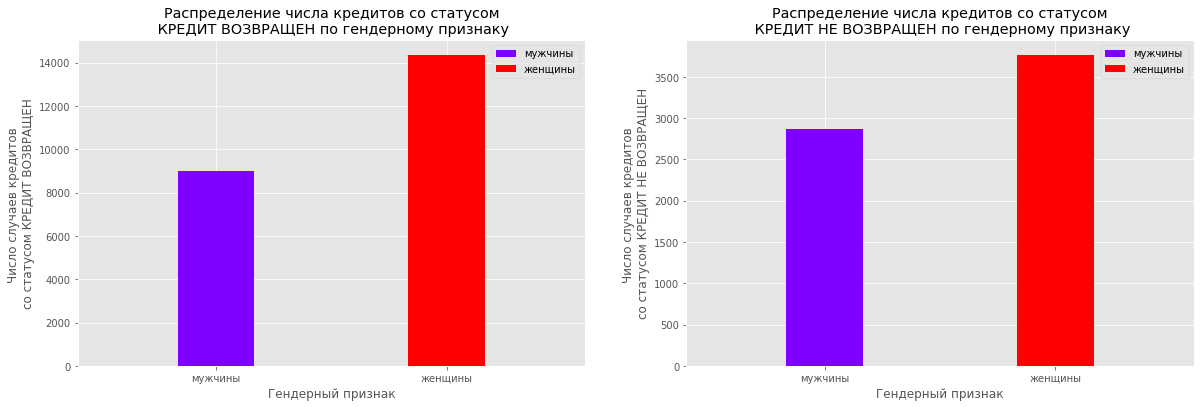

In [28]:
import matplotlib.cm as cm

colors = [np.array(cm.rainbow(i)).reshape(1,4) for i in np.linspace(0, 1, len(SEX))]

fig, nx = pyplot.subplots(1, 2, figsize=(20,6))

for feature, name in zip(default.keys(), default.values()):
    pyplot.subplot(1,2,feature+1)
    for index, label, color in zip(SEX.keys(), SEX.values(), colors):
        pyplot.hist(data[(data['default'] == feature) & (data['SEX'] == index)]['SEX'],
                    bins=3, color = color, label=label) 
    pyplot.title(f'Распределение числа кредитов со статусом\n {name.upper()} по гендерному признаку')
    pyplot.ylabel(f'Число случаев кредитов \nсо статусом {name.upper()}')
    pyplot.xlabel('Гендерный признак')
    pyplot.xticks(list(SEX.keys()), list(SEX.values()))
    pyplot.legend()
    
pyplot.show()

По графикам видно:
* соотношение мужчин в группах людей выплативших и невыплативших кредит, меньше;
* в группе выплативших кредит людей соотношение мужчин меньше, чем в группе невыплативших;
* женщины чаще берут кредиты.

In [20]:
table = pd.crosstab(index=data['default'], 
                    columns=data['SEX'], 
                    margins=True, 
                    margins_name='СУММАРНО', 
                    normalize='index')

table.index = np.append(list(default.values()), 'СУММАРНО')
table.columns = list(SEX.values())

table

,мужчины,женщины
кредит возвращен,0.385850,0.614150
кредит не возвращен,0.432942,0.567058
СУММАРНО,0.396267,0.603733


Из таблицы видно, что женщины в 1.5 раза чаще берут кредиты.

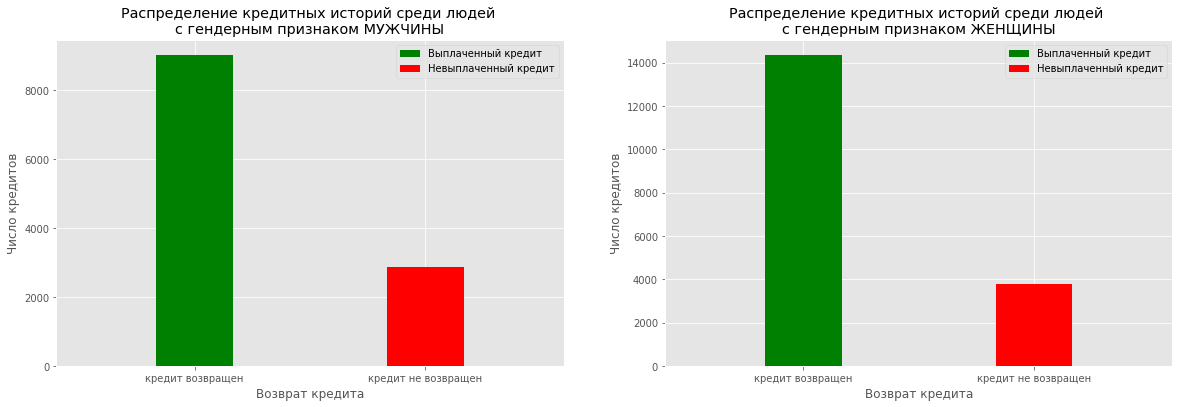

In [302]:
fig, nx = pyplot.subplots(1, 2, figsize=(20,6))

for index, label in zip(SEX.keys(), SEX.values()):
    pyplot.subplot(1,2,index)
    pyplot.hist(data[(data['default'] == 0) & (data['SEX'] == index)]['default'],
                bins=3, color = 'g', label='Выплаченный кредит')
    pyplot.hist(data[(data['default'] == 1) & (data['SEX'] == index)]['default'],
                bins=3, color = 'r', label='Невыплаченный кредит')
    pyplot.title(f'Распределение кредитных историй среди людей \nс гендерным признаком {label.upper()}')
    pyplot.ylabel('Число кредитов')
    pyplot.xlabel('Возврат кредита')
    pyplot.xticks(list(default.keys()), list(default.values()))
    pyplot.legend()

pyplot.show()

По графикам видно:
* соотношение мужчин, не возвративших кредит, больше, чем соотношение не возвративших кредит женщин;
* женщины чаще берут кредиты.

In [21]:
table = pd.crosstab(index=data['default'], 
                    columns=data['SEX'], 
                    margins=True, 
                    margins_name='СУММАРНО', 
                    normalize='columns')

table.index = list(default.values())
table.columns = np.append(list(SEX.values()), 'СУММАРНО')

table

,мужчины,женщины,СУММАРНО
кредит возвращен,0.758328,0.792237,0.7788
кредит не возвращен,0.241672,0.207763,0.2212


Из таблицы видно, что доля мужчины, которые не вернули кредит составляет 0.242. Доля женщин не вернувших кредит составляет 0.208. Исходя из данных соотношений предполагается гипотеза, что мужчины чаще не возвращают кредиты. Однако в данной оценке не учтено общее количество человек среди представителей обоих полов, из чего следует невозможность сделать вывод о влиянии гендерного признака на вероятность возврата кредита. Необходима интервальная оценка.

#### 2.2 Интервальная оценка

$H_0\colon$ среднее значение вероятности возврата кредита для обоих полов равно.

$H_1\colon$ не равно.

Воспользуемся Z-критерием для разности долей независимых выборок

**Таблица сопряженности**

|      |$X_1$|$X_2$|
|------|-----|-----|
|  1   |  a  |  b  |
|  0   |  c  |  d  |
|$\sum$|$n_1$|$n_2$|


$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$

где $a$, $b$ - число успехов в 1-ой и 2-ой выборках, размеров $n_1$ и $n_2$ соответственно.


$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$


$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [94]:
def proportions_diff_confint_ind(crosstab, alpha = 0.05):  
    """Возвращает границы доверительного интервала"""
    z = scipy.stats.norm.ppf(1 - alpha / 2)
    
    n1 = np.array(crosstab)[0,0] + np.array(crosstab)[1,0]
    n2 = np.array(crosstab)[0,1] + np.array(crosstab)[1,1]
    
    p1 = np.array(crosstab)[0,0] / n1
    p2 = np.array(crosstab)[0,1] / n2
    
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    
    return (left_boundary, right_boundary)


def proportions_diff_z_stat_ind(crosstab):
    """Возвращает Z-статистику"""
    n1 = np.array(crosstab)[0,0] + np.array(crosstab)[1,0]
    n2 = np.array(crosstab)[0,1] + np.array(crosstab)[1,1]
    
    p1 = np.array(crosstab)[0,0] / n1
    p2 = np.array(crosstab)[0,1] / n2
    
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))


def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    """Возвращает значение p-value"""
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [95]:
crosstab = pd.crosstab(index=data['default'], 
                       columns=data['SEX'])

crosstab.index = list(default.values())
crosstab.columns = list(SEX.values())

crosstab

,мужчины,женщины
кредит возвращен,9015,14349
кредит не возвращен,2873,3763


In [96]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(crosstab))

95% confidence interval for a difference between proportions: [-0.043612, -0.024207]


95%-ый доверительный интервал лежит левее нуля, не включая последний, из чего можно сделать вывод, что **мужчины чаще женщин не отдают кредиты**.

In [97]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(crosstab)))

p-value: 0.000000


Значение p-value для двусторонней альтернативы меньше 0.05, что позволяет опровергнуть нулевую гипотезу, о равенстве долей на уровне значимости 0.05. **Влиянии гендерного признака на вероятность возврата кредита статистически значимо.**

#### 2.3 Корреляция Мэтьюса

Коэффициент корреляции Мэтьюса — это мера силы взаимосвязи между двумя бинарными переменными.

Коэффициент корреляции Мэтьюса лежит в диапазоне от −1 до 1. ${MCC}_{X_1X_2}=0$ соответствует случаю полного отсутствия взаимосвязи между переменными. ${MCC}_{X_1X_2}=1$ соответствует ситуации, когда $X_1$ и $X_2$ полностью совпадают, то есть $b=c=0$, в выборке отсутствуют объекты, на которых значения $X_1$ и $X_2$ отличаются. ${MCC}_{X_1X_2}=-1$ — это противоположная ситуация: в выборке нет ни одного объекта, на которых значения двух бинарных признаков совпадают.

Таблица сопряженности


|X1\X2| 0 | 1 |
|-----|---|---|
|  0  | a | b |
|  1  | c | d |

$${MCC}_{X_1X_2}=\frac{ad-bc}{\sqrt{\left(a+b\right)\left(a+c\right)\left(b+d\right)\left(c+d\right)}}$$

In [101]:
def correlation_metyus(crosstab):
    """Возвращает коэффициент корреляции Мэтьюса"""
    a = np.array(crosstab)[0,0]
    b = np.array(crosstab)[0,1]
    c = np.array(crosstab)[1,0]
    d = np.array(crosstab)[1,1]
    
    correlation_metyus = (a*d - b*c) / np.sqrt((a+b)*(a+c)*(b+d)*(c+d))
    
    return correlation_metyus

In [349]:
crosstab = pd.crosstab(index=data['default'], 
                       columns=data['SEX'])

crosstab.index = list(default.values())
crosstab.columns = list(SEX.values())

crosstab

,мужчины,женщины
кредит возвращен,9015,14349
кредит не возвращен,2873,3763


In [102]:
correlation = correlation_metyus(crosstab)
print(round(correlation, 3))

-0.04


Значение корреляции Мэтьюса между гендерным признаком и вероятность возврата кредита не нулевое. **Гендерный признак влияет на вероятность возврата кредита.**

**Достигаемый уровень значимости корреляции Мэтьюса между гендерным признаком и вероятность возврата кредита**

In [348]:
from scipy.stats import chi2_contingency

$H_0:{MCC}_{X_1X_2}=0$

$H_1:{MCC}_{X_1X_2}\neq0$

In [352]:
# Проверка статистической значимости гипотезы с помощью критерия хи-квадрат
contingency = chi2_contingency(np.array(crosstab))
print(f'p-value:{contingency[1]}')

p-value:4.944678999412044e-12


Значение p-value значительно меньше 0.05, что позволяет отвергнуть нулевую гипотезу на уровне значимости 0.05. Корреляция между гендерным признаком и вероятность возврата кредита является статистически значимой.

### Задача 3

Проверить гипотезу о том, что образование (`EDUCATION`) не влияет на то, вернет ли человек долг.

#### 3.1 Точечная оценка

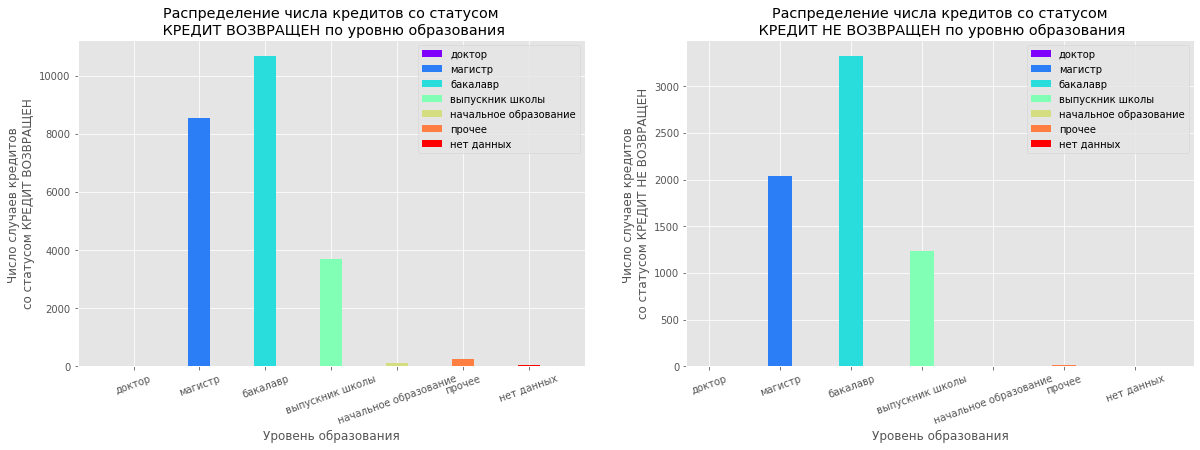

In [42]:
colors = [np.array(cm.rainbow(i)).reshape(1,4) for i in np.linspace(0, 1, len(EDUCATION))]

fig, nx = pyplot.subplots(1, 2, figsize=(20,6))

for feature, name in zip(default.keys(), default.values()):
    pyplot.subplot(1,2,feature+1)
    for index, label, color in zip(EDUCATION.keys(), EDUCATION.values(), colors):
        pyplot.hist(data[(data['default'] == feature) & (data['EDUCATION'] == index)]['EDUCATION'],
                    bins=3, color = color, label=label) 
    pyplot.title(f'Распределение числа кредитов со статусом\n {name.upper()} по уровню образования')
    pyplot.ylabel(f'Число случаев кредитов \nсо статусом {name.upper()}')
    pyplot.xlabel('Уровень образования')
    pyplot.xticks(list(EDUCATION.keys()), list(EDUCATION.values()), rotation=20)
    pyplot.legend()
    
pyplot.show()

Из графика видно:
* чаще всего кредит берут люди с уровнем образования 'магистр', 'бакалавр', реже 'выпускник школы'

In [425]:
table = pd.crosstab(index=data['default'], 
                    columns=data['EDUCATION'], 
                    margins=True, 
                    margins_name='СУММАРНО', 
                    normalize='index')

table.index = np.append(list(default.values()), 'СУММАРНО')
table.columns = list(EDUCATION.values())

table

,доктор,магистр,бакалавр,выпускник школы,начальное образование,прочее,нет данных
кредит возвращен,0.000599,0.365905,0.457970,0.157507,0.004965,0.011214,0.001840
кредит не возвращен,0.000000,0.306811,0.501808,0.186407,0.001055,0.002712,0.001206
СУММАРНО,0.000467,0.352833,0.467667,0.163900,0.004100,0.009333,0.001700


Из таблицы видно, что чаще всего кредит берут люди с уровнем образования 'магистр', 'бакалавр', реже 'выпускник школы'. 

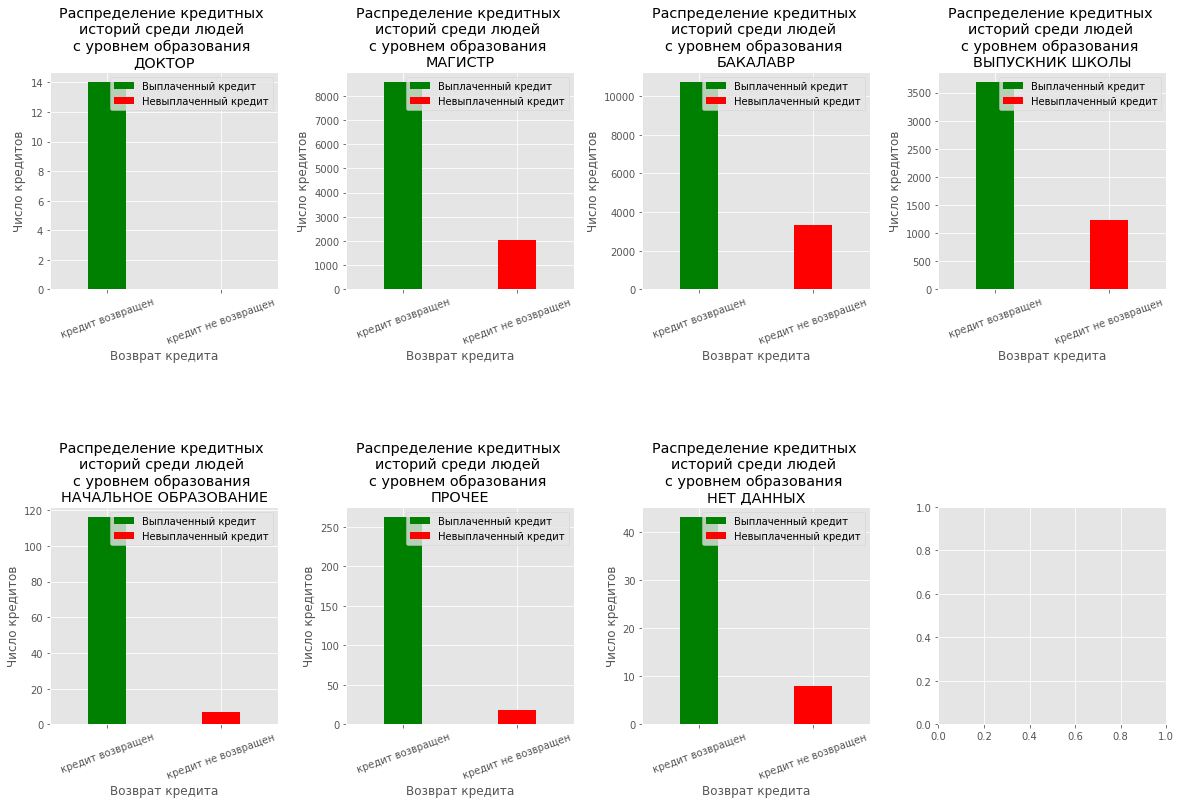

In [44]:
fig, nx = pyplot.subplots(2, 4, figsize=(20,12))

for index, label in zip(EDUCATION.keys(), EDUCATION.values()):
    pyplot.subplot(2,4,index+1)
    pyplot.hist(data[(data['default'] == 0) & (data['EDUCATION'] == index)]['default'],
                bins=3, color = 'g', label='Выплаченный кредит')
    pyplot.hist(data[(data['default'] == 1) & (data['EDUCATION'] == index)]['default'],
                bins=3, color = 'r', label='Невыплаченный кредит')
    pyplot.title(f'Распределение кредитных \nисторий среди людей \nс уровнем образования \n{label.upper()}')
    pyplot.ylabel('Число кредитов')
    pyplot.xlabel('Возврат кредита')
    pyplot.xticks(list(default.keys()), list(default.values()), rotation=20)
    pyplot.xlim(-0.5, 1.5)
    pyplot.legend()

pyplot.subplots_adjust(wspace=0.3, hspace=1)
pyplot.show()

In [362]:
table = pd.crosstab(index=data['default'], 
                    columns=data['EDUCATION'], 
                    margins=True, 
                    margins_name='СУММАРНО', 
                    normalize='columns')

table.index = list(default.values())
table.columns = np.append(list(EDUCATION.values()), 'СУММАРНО')

table

,доктор,магистр,бакалавр,выпускник школы,начальное образование,прочее,нет данных,СУММАРНО
кредит возвращен,1.0,0.807652,0.762651,0.748424,0.943089,0.935714,0.843137,0.7788
кредит не возвращен,0.0,0.192348,0.237349,0.251576,0.056911,0.064286,0.156863,0.2212


Из таблицы видно, что с увеличением уровня образования 'выпускника школы' - 'бакалавр' - 'магистр' - 'доктор', вероятность невозврата кредита снижается, что кажется логичным. Однако, у людей с 'начальным образованием' вероятность невозврата кредита значительно ниже предполагаемой. Отсюда можно предположить, что уровень образования не коррелирует с вероятностью невозврата кредита, однако данная оценка не учитывает количественное сотношение людей различного уровня образования, берущих кредит.

#### 3.2  Проверка на соответствие распределения равномерному с помощью критерия согласия Пирсона $\chi^2$

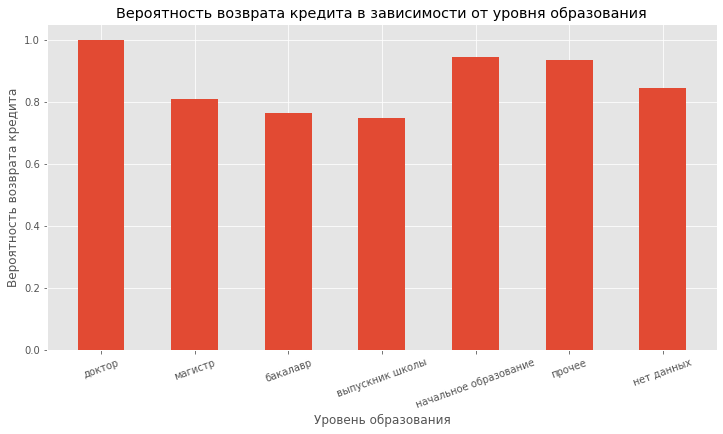

In [45]:
fig, nx = pyplot.subplots(figsize=(12,6))
pyplot.bar(x=list(EDUCATION.values()), 
           height=pd.crosstab(data['default'], data['EDUCATION'], normalize='columns').iloc[0,:], 
           width=0.5)
pyplot.title('Вероятность возврата кредита в зависимости от уровня образования')
pyplot.ylabel(f'Вероятность возврата кредита')
pyplot.xlabel('Уровень образования')
pyplot.xticks(rotation=20)
pyplot.show()

Из графика видно, что распределние вероятности возврата кредита в зависимости от уровня образования похоже на равномерное со средним `mean`. 

**Сравнение наблюдаемых и ожадаемых частот на случай равномерного распределения вероятности возврата кредита в зависимости от уровня образования со средним `mean`.**

In [48]:
# Наблюдаемые частоты возврата кредита в зависимости от уровня образования
observed_frequences = pd.crosstab(index=data['default'], columns=data['EDUCATION']).iloc[0,:]

# Среднее значение вероятности возврата кредита в зависимости от уровня образования
mean = np.mean(pd.crosstab(data['default'], data['EDUCATION'], normalize='columns').iloc[0,:])

# Ожидаемые частоты возврата кредита в зависимости от уровня образования
expected_frequences = pd.crosstab(index=data['default'], columns=data['EDUCATION'], margins=True).iloc[2,:-1] * mean

In [49]:
# Наблюдаемые частоты
observed_crosstab = pd.crosstab(index=data['default'], 
                    columns=data['EDUCATION'], 
                    margins=True, 
                    margins_name='СУММАРНО')

observed_crosstab.index = np.append(list(default.values()), 'СУММАРНО')
observed_crosstab.columns = np.append(list(EDUCATION.values()), 'СУММАРНО')

observed_crosstab

,доктор,магистр,бакалавр,выпускник школы,начальное образование,прочее,нет данных,СУММАРНО
кредит возвращен,14,8549,10700,3680,116,262,43,23364
кредит не возвращен,0,2036,3330,1237,7,18,8,6636
СУММАРНО,14,10585,14030,4917,123,280,51,30000


In [50]:
# Ожидаемые частоты
expected_crosstab = pd.DataFrame(
    np.array([
        pd.crosstab(index=data['default'], columns=data['EDUCATION'], margins=True).iloc[2,:] * mean,
        pd.crosstab(index=data['default'], columns=data['EDUCATION'], margins=True).iloc[2,:] * (1-mean),
        pd.crosstab(index=data['default'], columns=data['EDUCATION'], margins=True).iloc[2,:]
    ])
)

expected_crosstab.index = np.append(list(default.values()), 'СУММАРНО')
expected_crosstab.columns = np.append(list(EDUCATION.values()), 'СУММАРНО')

expected_crosstab

,доктор,магистр,бакалавр,выпускник школы,начальное образование,прочее,нет данных,СУММАРНО
кредит возвращен,12.081337,9134.353886,12107.225793,4243.13822,106.143177,241.626744,44.010586,25888.579742
кредит не возвращен,1.918663,1450.646114,1922.774207,673.86178,16.856823,38.373256,6.989414,4111.420258
СУММАРНО,14.000000,10585.000000,14030.000000,4917.00000,123.000000,280.000000,51.000000,30000.000000


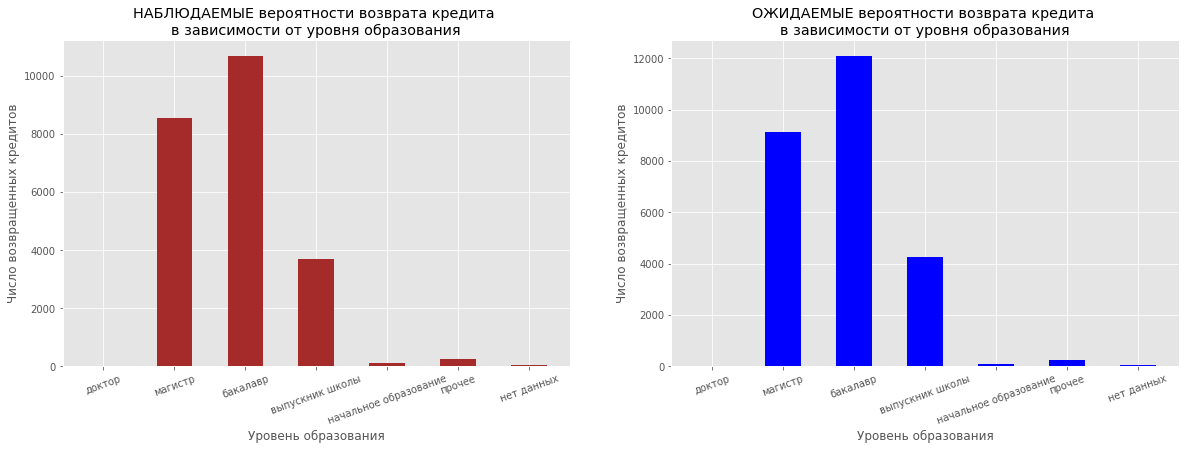

In [52]:
fig, nx = pyplot.subplots(1, 2, figsize=(20,6))

pyplot.subplot(1,2,1)
pyplot.bar(x=list(EDUCATION.values()), height=observed_crosstab.iloc[0,:-1], width=0.5, color='brown')
pyplot.title('НАБЛЮДАЕМЫЕ вероятности возврата кредита \nв зависимости от уровня образования')
pyplot.ylabel(f'Число возвращенных кредитов')
pyplot.xlabel('Уровень образования')
pyplot.xticks(rotation=20)

pyplot.subplot(1,2,2)
pyplot.bar(x=list(EDUCATION.values()), height=expected_crosstab.iloc[0,:-1], width=0.5, color='blue')
pyplot.title('ОЖИДАЕМЫЕ вероятности возврата кредита \nв зависимости от уровня образования')
pyplot.ylabel(f'Число возвращенных кредитов')
pyplot.xlabel('Уровень образования')
pyplot.xticks(rotation=20)

pyplot.show()

**Разница в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших кредит.**

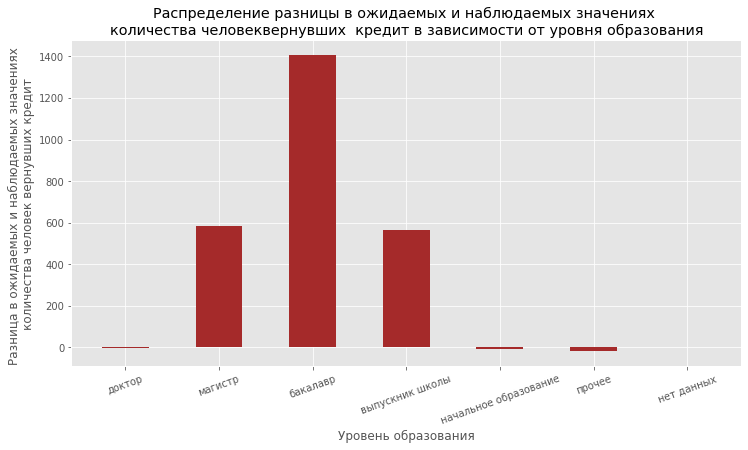

In [53]:
fig, nx = pyplot.subplots(figsize=(12,6))

pyplot.bar(x=list(EDUCATION.values()), 
           height=(expected_crosstab.iloc[0,:-1] - observed_crosstab.iloc[0,:-1]), 
           width=0.5, color='brown')
pyplot.title('Распределение разницы в ожидаемых и наблюдаемых значениях \nколичества человек\
вернувших  кредит в зависимости от уровня образования')
pyplot.ylabel(f'Разница в ожидаемых и наблюдаемых значениях \nколичества человек вернувших кредит')
pyplot.xlabel('Уровень образования')
pyplot.xticks(rotation=20)

pyplot.show()

Из графика видно, что разница между ожидаемыми и наблюдаемыми значениях количества человек вернувших кредит велика и сильно варьируется по уровням образования. Распределение вероятности возврата кредита от уровня образования не равномерное. Следовательно, вероятность возврата кредита меняется в зависимости от уровня образования.

**Строгая оценка соответствия распределения равномерному с помощью критерия согласия Пирсона $\chi^2$.** 

$H_0:$ Случайная величина распределена равномерно со средним `mean`

$H_1:$ Иначе

Статистика критерия хи-квадрат: $$\chi^2=\sum_{i=1}^K \frac{\left(n_i- np_i\right)^2}{np_i}$$
При справедливости нулевой гипотезы имеет распределение хи-квадрат с числом степеней свободы $K-1-m$, где $m$ - число параметров распределения, оцененных по выборке.

In [405]:
from scipy.stats import chisquare

In [537]:
chisquare(observed_frequences,expected_frequences, ddof = 1)

Power_divergenceResult(statistic=278.7725391716089, pvalue=3.653181595163598e-58)

p-value близко к нулю, значит на уровне значимости 0.05 можно отвергать нулевую гипотезу, данные распределены не нормально.

#### 3.3 Коэффициент V Крамера

Коэффициент V Крамера - это мера силы взаимосвязи между двумя категориальными признаками.

Коэффициент Крамера принимает значения исключительно в интервале от 0 до 1. 0 соответствует полному отсутствию взаимосвязи, а 1 — полному совпадению переменных $X_1$ и $X_2$ с точностью до переименования уровней.

Таблица сопряженности


|X1\X2| 1 |...|    j   |...|$K_2$|
|-----|---|---|--------|---|-----|
|  1  |   |   |        |   |     |
| ... |   |   |        |   |     |
|  i  |   |   |$n_{ij}$|   |     |
| ... |   |   |        |   |     |
|$K_1$|   |   |        |   |     |

$H_0:\varphi_c\left(X_1^n,\ X_2^n\right)=0$

$H_1:\varphi_c\left(X_1^n,\ X_2^n\right)\neq0$

In [418]:
crosstab = pd.crosstab(index=data['default'], 
                       columns=data['EDUCATION'])

crosstab.index = list(default.values())
crosstab.columns = list(EDUCATION.values())

crosstab

,доктор,магистр,бакалавр,выпускник школы,начальное образование,прочее,нет данных
кредит возвращен,14,8549,10700,3680,116,262,43
кредит не возвращен,0,2036,3330,1237,7,18,8


In [356]:
# Проверка статистической значимости гипотезы с помощью критерия хи-квадрат
contingency = chi2_contingency(np.array(crosstab))
print(f'statistic:{contingency[0]}')
print(f'p-value:{contingency[1]}')

statistic:163.21655786997073
p-value:1.2332626245415605e-32


Значение p-value значительно меньше 0.05, что позволяет отвергнуть нулевую гипотезу на уровне значимости 0.05. Корреляция между уровнем образования и вероятность возврата кредита является статистически значимой.

$$\varphi_c\left(X_1^n,\ X_2^n\right)=\sqrt{\frac{\chi^2\left(X_1^n,\ X_2^n\right)}{n\ \left(\min{\left(K_1,\ K_2\right)}-1\right)}}$$

In [358]:
v_kramer = np.sqrt(contingency[0] / (np.sum(np.array(crosstab)) * (np.min(np.array(crosstab).shape) - 1)))
print(v_kramer)

0.07376009713252163


Значение коэффициента Крамера свидетельствует о наличии корреляции между уровнем образования и вероятностью возврата кредита.

### Задача 4

Проверить, как связан семейный статус (`MARRIAGE`) с индикатором дефолта.

#### 4.1 Точечная оценка

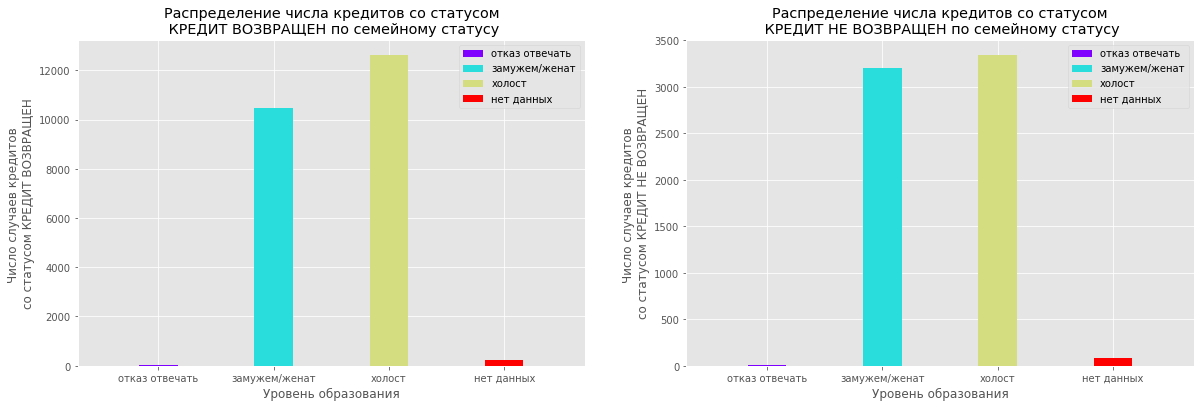

In [41]:
colors = [np.array(cm.rainbow(i)).reshape(1,4) for i in np.linspace(0, 1, len(MARRIAGE))]

fig, nx = pyplot.subplots(1, 2, figsize=(20,6))

for feature, name in zip(default.keys(), default.values()):
    pyplot.subplot(1,2,feature+1)
    for index, label, color in zip(MARRIAGE.keys(), MARRIAGE.values(), colors):
        pyplot.hist(data[(data['default'] == feature) & (data['MARRIAGE'] == index)]['MARRIAGE'],
                    bins=3, color = color, label=label) 
    pyplot.title(f'Распределение числа кредитов со статусом\n {name.upper()} по семейному статусу')
    pyplot.ylabel(f'Число случаев кредитов \nсо статусом {name.upper()}')
    pyplot.xlabel('Уровень образования')
    pyplot.xticks(list(MARRIAGE.keys()), list(MARRIAGE.values()), rotation=0)
    pyplot.legend()
    
pyplot.show()

In [279]:
table = pd.crosstab(index=data['default'], 
                    columns=data['MARRIAGE'], 
                    margins=True, 
                    margins_name='СУММАРНО', 
                    normalize='index')

table.index = np.append(list(default.values()), 'СУММАРНО')
table.columns = list(MARRIAGE.values())

table

,отказ отвечать,замужем/женат,холост,нет данных
кредит возвращен,0.002097,0.447398,0.540276,0.010229
кредит не возвращен,0.000753,0.483122,0.503466,0.012658
СУММАРНО,0.001800,0.455300,0.532133,0.010767


Из таблицы видно, что чаще всего кредит берут люди с семейным статусом 'замужем/женат' и 'холост'.

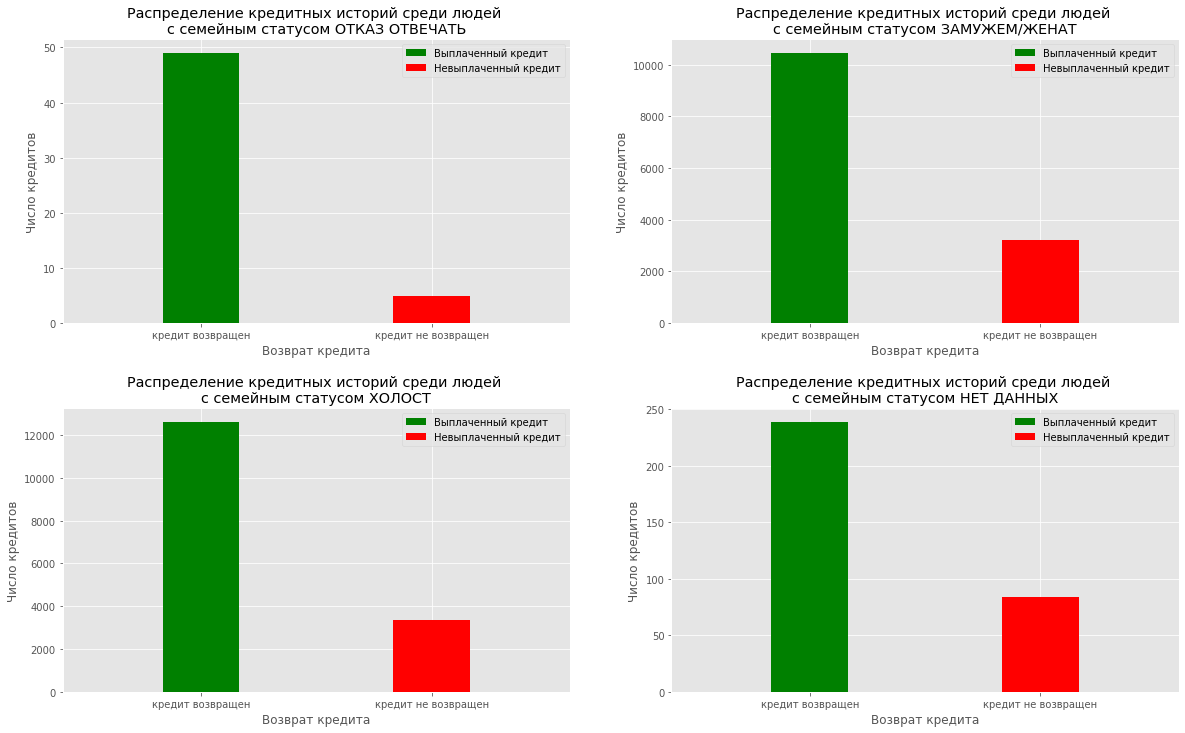

In [554]:
fig, nx = pyplot.subplots(2, 2, figsize=(20,12))

for index, label in zip(MARRIAGE.keys(), MARRIAGE.values()):
    pyplot.subplot(2,2,index+1)
    pyplot.hist(data[(data['default'] == 0) & (data['MARRIAGE'] == index)]['default'],
                bins=3, color = 'g', label='Выплаченный кредит')
    pyplot.hist(data[(data['default'] == 1) & (data['MARRIAGE'] == index)]['default'],
                bins=3, color = 'r', label='Невыплаченный кредит')
    pyplot.title(f'Распределение кредитных историй среди людей \nс семейным статусом {label.upper()}')
    pyplot.ylabel('Число кредитов')
    pyplot.xlabel('Возврат кредита')
    pyplot.xticks(list(default.keys()), list(default.values()))
    pyplot.legend()

pyplot.subplots_adjust(wspace=0.2, hspace=0.3)
pyplot.show()

In [280]:
table = pd.crosstab(index=data['default'], 
                    columns=data['MARRIAGE'], 
                    margins=True, 
                    margins_name='СУММАРНО', 
                    normalize='columns')

table.index = list(default.values())
table.columns = np.append(list(MARRIAGE.values()), 'СУММАРНО')

table

,отказ отвечать,замужем/женат,холост,нет данных,СУММАРНО
кредит возвращен,0.907407,0.765283,0.790717,0.739938,0.7788
кредит не возвращен,0.092593,0.234717,0.209283,0.260062,0.2212


Из таблицы видно, что люди с семейным статусом 'замужем/женат', 'холост', 'нет данных' возвращают кредит с вероятностью в интервале 0.74-0.79 с небольшой разницей. Отказавшиеся раскрывать свой семейный статус люди возвращают кредиты с вероятностью более 90%. Это может объясняться тем, что не желают раскрывать свой семейный статус люди с высоким уровнем достатка.

#### 4.2 Коэффициент V Крамера

$H_0:\varphi_c\left(X_1^n,\ X_2^n\right)=0$

$H_1:\varphi_c\left(X_1^n,\ X_2^n\right)\neq0$

In [551]:
crosstab = pd.crosstab(index=data['default'], 
                       columns=data['MARRIAGE'])

crosstab.index = list(default.values())
crosstab.columns = list(MARRIAGE.values())

crosstab

,отказ отвечать,замужем/женат,холост,нет данных
кредит возвращен,49,10453,12623,239
кредит не возвращен,5,3206,3341,84


In [552]:
# Проверка статистической значимости гипотезы с помощью критерия хи-квадрат
contingency = chi2_contingency(np.array(crosstab))
print(f'statistic:{contingency[0]}')
print(f'p-value:{contingency[1]}')

statistic:35.66239583433609
p-value:8.825862457577375e-08


Значение p-value значительно меньше 0.05, что позволяет отвергнуть нулевую гипотезу на уровне значимости 0.05. Корреляция между семейным статусом и вероятностью возврата кредита является статистически значимой.

$$\varphi_c\left(X_1^n,\ X_2^n\right)=\sqrt{\frac{\chi^2\left(X_1^n,\ X_2^n\right)}{n\ \left(\min{\left(K_1,\ K_2\right)}-1\right)}}$$

In [553]:
v_kramer = np.sqrt(contingency[0] / (np.sum(np.array(crosstab)) * (np.min(np.array(crosstab).shape) - 1)))
print(v_kramer)

0.034478203662766466


Значение коэффициента Крамера свидетельствует о наличии корреляции между семейным статусом и вероятностью возврата кредита.

### Задача 5

Относительно двух групп людей вернувших и не вернувших кредит проверить следующие гипотезы: 
    
    a) о равенстве медианных значений возрастов людей (`AGE`)
    b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

#### 5.1 Точечная оценка

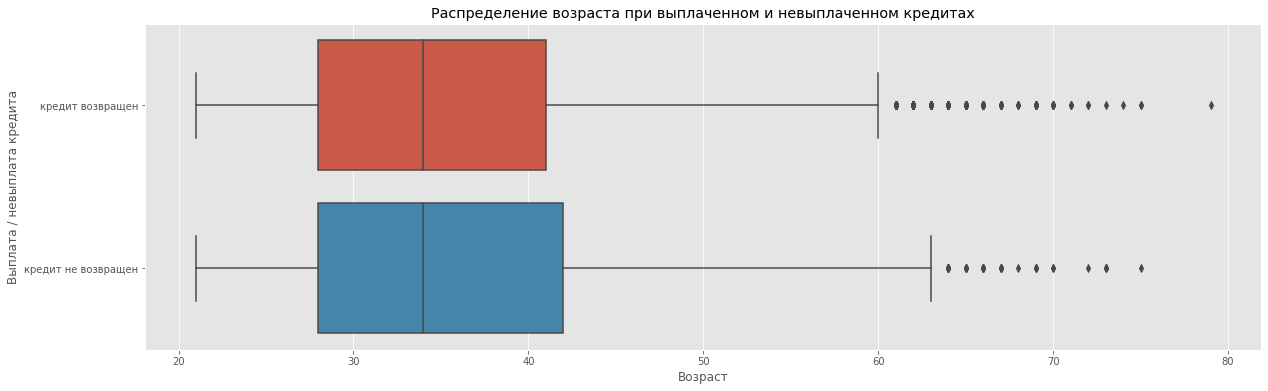

In [58]:
fig, nx = pyplot.subplots(figsize=(20,6))

sns.boxplot(y='default', x='AGE', data=data, orient='h')

pyplot.title(f'Распределение возраста при выплаченном и невыплаченном кредитах')
pyplot.ylabel('Выплата / невыплата кредита')
pyplot.xlabel('Возраст')
pyplot.yticks(list(default.keys()), list(default.values()))
pyplot.ylim(1.5, -0.5)
    
pyplot.show()

По boxplot видно: 
* области интерквантильных размахов [25%-й квантиль, 75%-й квантиль] пересекаются и практически совпадают;
* медиана возраста при выплаченных и невыплаченных совпадает;
* возраст в обоих случаях выплаты имеет тяжелые хвосты, выходящие за  1.5-ый интерквартильный размах в большую сторону 

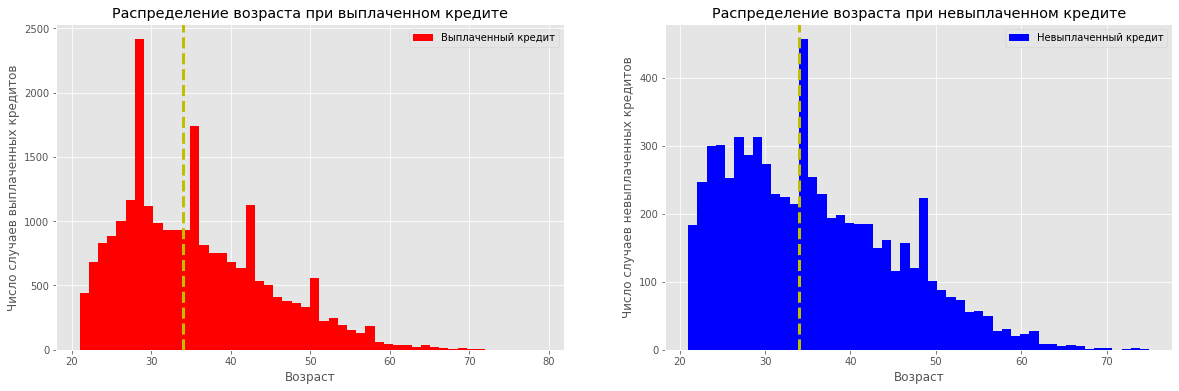

In [59]:
fig, nx = pyplot.subplots(1, 2, figsize=(20,6))

pyplot.subplot(1,2,1)
pyplot.hist(data[data['default'] == 0]['AGE'], bins=50, color = 'r', label='Выплаченный кредит')
pyplot.axvline(np.median(data[data['default'] == 0]['AGE']), color='y', linestyle='dashed', linewidth=3)
pyplot.title(f'Распределение возраста при выплаченном кредите')
pyplot.ylabel('Число случаев выплаченных кредитов')
pyplot.xlabel('Возраст')
pyplot.legend()

pyplot.subplot(1,2,2)
pyplot.hist(data[data['default'] == 1]['AGE'], bins=50, color = 'b', label='Невыплаченный кредит')
pyplot.axvline(np.median(data[data['default'] == 1]['AGE']), color='y', linestyle='dashed', linewidth=3)
pyplot.title(f'Распределение возраста при невыплаченном кредите')
pyplot.ylabel('Число случаев невыплаченных кредитов')
pyplot.xlabel('Возраст')
pyplot.legend()

pyplot.show()

По гистограммам размеров кредитных лимитов при обоих вариантах выплыт видно:
* максимальный возраст людей, выплативших кредит, выше такового для невыплативших;
* пик выплат приходится на возраст 30 лет;
* пик невыплат приходится на возраст 25 лет.

#### 5.2 Проверка гипотезы о равенстве медианных значений возраста в группах людей, кто вернул кредит и тех, кто его не вернул

$H_0$: $med_{default=0}=med_{default=1}$

$H_1$: $med_{default=0}\neq med_{default=1}$

Применим интервальную оценку медианы для каждой из двух выборок

In [86]:
# В качестве статистики используется медиана (np.median)
np.random.seed(0)

data_0 = data[data['default'] == 0]['AGE'].values
data_1 = data[data['default'] == 1]['AGE'].values

# Получение списков статистик (медиан)
# Количество подвыборок задается одинаковым не смотря на разницу в объемах данных для различных групп
data_0_median_scores = list(map(np.median, get_bootstrap_samples(data_0, 10000)))
data_1_median_scores = list(map(np.median, get_bootstrap_samples(data_1, 10000)))

# По набору статистик строится 95%-ый доверительный интервал статистики
print("95% confidence interval for data_0:",  stat_intervals(data_0_median_scores, 0.05))
print("95% confidence interval for data_1:",  stat_intervals(data_1_median_scores, 0.05))

95% confidence interval for data_0: [34. 34.]
95% confidence interval for data_1: [34. 35.]


По полученным оценкам видно, что медианная величина возраста в группах людей, не выплативших кредит, выше, чем таковая для людей, выплативших кредит.

Для получения более точных данных применим интервальную оценку разности медиан двух выборок

In [67]:
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(data_0_median_scores, data_1_median_scores)))

In [68]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-1.  0.]


**Таким образом видно, что разница между медианными значениями величины возраста в группах людей, не выплативших кредит, и людей, выплативших кредит, находится в диапазоне [0. 1.]. Медиана возраста при не выплаченных кредитах больше таковой при выплаченных.**

Данная разница не является значимой с практической точки зрения.

#### 5.3 Проверка гипотезы о равенстве распределений значений возраста в группах людей, кто вернул кредит и тех, кто его не вернул

**Перестановочный критерий**

Нулевая гипотеза: функции распределения для первой и второй выборки одинаковы.

Альтернативная гипотеза: функция распределения одной выборки получается сдвигом на некоторую дельту из функции распределения на другой выборке.


$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [89]:
# p-value при ограничении на количество перестановок в 10000
print("p-value: %f" % permutation_test(data_0, data_1, max_permutations = 10000))

p-value: 0.016100


Значение p-value меньше 0.05, что позволяет отвергнуть нулевую гипотезу на уровне значимости 0.05. **Распределение значений возраста в группах людей, кто вернул кредит и тех, кто его не вернул отличаются.**

**Ранговый критерий Манна-Уитни**

Нулевая гипотеза: вероятность того, что значение из первой выборки будет больше, чем значение из второй выборки, равна вероятности того, что значение из второй выборки будет больше, чем значение из первой выборки.

Альтернативная гипотеза: не равна.


$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [90]:
stats.mannwhitneyu(data_0, data_1)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

p-value больше 0.05, что не позволяет отвергнуть нулевую гипотезу, нельзя сказать, что распределения значений возраста в группах людей, кто вернул кредит и тех, кто его не вернул отличаются.

Перестановочный критерий и Ранговый критерий Манна-Уитни дали противоположные результаты. Однако, поскольку Перестановочный критерий теряет меньше информации, чем Ранговый критерий Манна-Уитни, следует доверять его значению.